In [7]:
#### Hello, there's some instructions in the third notebook cell (or just search for '####' or ask me) :) have fun

import pandas as pd, numpy as np
import json
from pandas import json_normalize
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
import os, datetime, matplotlib

sns.set_theme(style="white")
savefig_colour = '#BFD7EA'
yellow_colour = '#FF9505'
pink_colour = '#D64045'
primary_colour = '#0A3200'

plt.rcParams.update({
    "figure.facecolor":  savefig_colour,
    "axes.facecolor":    savefig_colour,
    "savefig.facecolor": savefig_colour,
    "axes.titlesize": 'large',
    "axes.labelsize": 'medium',
})
font = {'weight' : 'bold',
        'size'   :  15}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


In [8]:
def LoadJSONPlaylists(folder, filename):
    filepath = folder + "/" + filename + ".json"
    with open(filepath, 'r', encoding='utf8') as fcc_file:
        df = pd.json_normalize(json.load(fcc_file), record_path='playlists')
    return df

def LoadJSONStreamingHistory(folder):
    files = [f for f in os.listdir(folder) if "StreamingHistory" in f]
    stream_hist = pd.DataFrame()
    for f in files:
        filepath = folder + "/" + f
        stream_hist = pd.concat([stream_hist, pd.read_json(filepath)]).reset_index(drop=True)

    total_songs_listened_to = len(stream_hist)
    total_unique_songs_listened_to = len(np.unique(stream_hist['trackName'].to_numpy()))
    total_artists_listened_to = len(np.unique(stream_hist['artistName'].to_numpy()))
    total_time_listened = np.sum(stream_hist['msPlayed'].to_numpy())

    stream_hist['endTime'] = pd.to_datetime(stream_hist['endTime'], format="%Y-%m-%d %H:%M")
    stream_hist['Date'] = stream_hist.apply(lambda row: row.endTime.date(), axis=1)
    stream_hist['Date'] = pd.to_datetime(stream_hist['Date'], format='%Y-%m-%d')
    stream_hist['Weekday'] = stream_hist.apply(lambda row: row.endTime.weekday(), axis=1)
    stream_hist['Day'] = stream_hist.apply(lambda row: row.endTime.timetuple().tm_yday, axis=1)
    stream_hist['Time'] = stream_hist.apply(lambda row: row.endTime - row.Date, axis=1)
    stream_hist['Time'] = pd.to_timedelta(stream_hist['Time'])
    stream_hist['Seconds'] = stream_hist.apply(lambda row: (row.Time).total_seconds(), axis=1)
    stream_hist['SecondsSinceYearStart'] = stream_hist.apply(lambda row: (row.endTime - pd.Timestamp(datetime.datetime(2022,1,1,00,00,00).date())).total_seconds(), axis=1)

    stream_hist = stream_hist[stream_hist['endTime'] >= datetime.datetime(2022,1,1,00,00,00)]
    stream_hist = stream_hist[stream_hist['endTime'] <= datetime.datetime(2022,11,1,00,00,00)]
    return stream_hist, total_songs_listened_to, total_unique_songs_listened_to, total_artists_listened_to, total_time_listened


In [9]:
#### Hi, I think all you should need to do is make sure you have the packages installed from the top cell (numpy, pandas, etc...)
####    and then in the line below here, download and unzip your spotify data and save all of the .json files into a folder called 'MyData' in the same place where this python code is located
####    just let me know if it doesn't work

# def Top5(df, column):

stream_hist, total_songs_listened_to, total_unique_songs_listened_to, total_artists_listened_to, total_time_listened = LoadJSONStreamingHistory("MyData")

yearly_songs_listened_to = len(stream_hist)
yearly_unique_songs_listened_to = len(np.unique(stream_hist['trackName'].to_numpy()))
yearly_artists_listened_to = len(np.unique(stream_hist['artistName'].to_numpy()))
yearly_time_listened = np.sum(stream_hist['msPlayed'].to_numpy())

percent_songs = round(yearly_songs_listened_to * 100 / total_songs_listened_to, 2)
percent_unique_songs = round(yearly_unique_songs_listened_to * 100 / total_unique_songs_listened_to, 2)
percent_artists = round(yearly_artists_listened_to * 100 / total_artists_listened_to, 2)
percent_time_listened = round(yearly_time_listened * 100 / total_time_listened, 2)

song_rankings = stream_hist.groupby(['trackName'], as_index=False).agg({'msPlayed': 'sum', 'artistName': 'first'}).sort_values(by='msPlayed', ascending=False)
artist_rankings = stream_hist.groupby(['artistName'], as_index=False).agg({'msPlayed': 'sum'}).sort_values(by='msPlayed', ascending=False)

length = 5
songs = song_rankings['trackName'].iloc[0:length]
song_artists = song_rankings['artistName'].iloc[0:length]
artists = artist_rankings['artistName'].iloc[0:length]
song_times = song_rankings['msPlayed'].iloc[0:length]
artist_times = artist_rankings['msPlayed'].iloc[0:length]

time_listened_per_day = stream_hist.groupby(['Day'], as_index=False).agg({'msPlayed': 'sum', 'Day': 'first'}).sort_values(by='Day')

In [10]:
def addlabels(x,y, val):
    for i in range(len(x)):
        plt.text(np.min(x)/2, y[i], str(val[i])+"%", ha='center', va='center')

palette = 'GnBu_r'

def TopArtists(stream_hist):
    fig = plt.figure(figsize=(10,8))
    ax = sns.barplot(artist_times/(1000*60), artists, hue=artists, palette=palette, dodge=False, edgecolor=None, linewidth=0)
    plt.xlabel("Minutes Listened")
    plt.ylabel("")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().get_yaxis().tick_left()
    plt.gca().get_xaxis().tick_bottom()
    plt.title("Time spent listening to your top artists")
    plt.gca().get_legend().remove()
    addlabels(artist_times.to_numpy()/(1000*60), np.arange(len(artists)), np.around(artist_times.to_numpy()*100/yearly_time_listened, 2))
    plt.savefig("TopArtists.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

def TopSongs(stream_hist):
    fig = plt.figure(figsize=(10,8))
    ax = sns.barplot(song_times/(1000*60), songs, hue=song_artists, palette=palette, dodge=False, edgecolor=None, linewidth=0)
    plt.xlabel("Minutes Listened")
    plt.ylabel("")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().get_yaxis().tick_left()
    plt.gca().get_xaxis().tick_bottom()
    plt.title("Time spent listening to your favourite songs")
    box = plt.gca().get_position()
    plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    addlabels(song_times.to_numpy()/(1000*60), np.arange(len(songs)), np.around(song_times.to_numpy()*100/yearly_time_listened, 2))
    plt.gca().get_legend().remove()
    plt.savefig("TopSongs.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

def TimeOfDay(stream_hist):
    fig = plt.figure(figsize=(12,4))
    plt.hist(stream_hist['Seconds'].to_numpy(), bins=24*6, edgecolor=None, linewidth=0, color='cornflowerblue', align='mid')
    plt.xticks(np.linspace(0, 86400, 13), ["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00","00:00"])
    plt.title("What time of day do you listen to Spotify most?")
    plt.ylabel("Minutes Listened")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().get_yaxis().tick_left()
    plt.gca().get_xaxis().tick_bottom()
    counts, midpoints = np.histogram(stream_hist['Seconds'].to_numpy(), bins=24*6)
    plt.gca().vlines(midpoints[np.argmax(counts)], 0, np.max(counts)*1.05, linestyle='dashed', color='white', linewidth=1)
    plt.gca().annotate(datetime.timedelta(seconds=int(midpoints[np.argmax(counts)])), (midpoints[np.argmax(counts)], 1.05*np.max(counts)), ha='center')
    plt.savefig("TimeOfDay.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

def TimeOfYear(time_listened_per_day):
    plt.figure(figsize=(12,4))
    time_listened, day = time_listened_per_day['msPlayed'].to_numpy()/(1000*60), time_listened_per_day['Day'].to_numpy()
    # print(len(day))
    plt.bar(day, time_listened, edgecolor=None, linewidth=0, color='cornflowerblue', align='center')
    # sns.regplot(x=day, y=time_listened)
    plt.xticks(np.linspace(0, 365, 12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.title("Your listening throughout the year")
    plt.ylabel("Minutes Listened")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().get_yaxis().tick_left()
    plt.gca().get_xaxis().tick_bottom()
    # plt.gca().vlines(day[np.argmax(time_listened)], 0, np.max(time_listened)*1.05, linestyle='dashed', color='white', linewidth=1)
    offset = datetime.date(2022,1,1) + datetime.timedelta(int(day[np.argmax(time_listened)]))
    plt.gca().annotate(offset.strftime('%d %b'), (day[np.argmax(time_listened)], 1.05*np.max(time_listened)), ha='center')
    plt.savefig("TimeOfYear.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

def DayOfWeek(stream_hist):
    fig = plt.figure(figsize=(10,8))
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    sns.histplot(x=stream_hist['Weekday'], bins=7, palette=palette, discrete=True)
    # plt.hist(stream_hist['Weekday'].to_numpy(), bins=7, edgecolor=None, linewidth=0, color='cornflowerblue', align='left')
    plt.xticks(np.arange(7), days)
    plt.title("Which day do you listen to Spotify most?")
    plt.ylabel("Minutes Listened")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().get_yaxis().tick_left()
    plt.gca().get_xaxis().tick_bottom()
    plt.savefig("DayOfWeek.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

def TopArtistsTimeOfYear(stream_hist, artists):
    colours = [matplotlib.colors.rgb2hex(plt.cm.get_cmap('GnBu_r', 5)(i)) for i in range(plt.cm.get_cmap('GnBu_r', 5).N)]
    arts = artists.values
    fig = plt.figure(figsize=(10,8))
    gs = fig.add_gridspec(len(arts), hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    fig.suptitle('Top Artists\' Listening During the Year')

    y_vals = []
    for a in range(len(arts)):
        sns.kdeplot(stream_hist[stream_hist['artistName']==arts[a]]['Day'], shade=True, ax=axs[a], color=colours[a], alpha=1)
        axs[a].get_yaxis().set_visible(False)
        if a == 0: axs[a].spines['top'].set_visible(False)
        axs[a].spines['left'].set_visible(False)
        axs[a].spines['right'].set_visible(False)
        y_vals.append(axs[a].get_ylim()[1])

    [axs[a].text(-25, np.mean(y_vals), arts[a], fontweight='bold', fontsize=15, color='k') for a in np.arange(len(arts))]
    plt.xticks(np.linspace(0, 365, 12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.xlim(-50,415)
    plt.xlabel("")
    fig = plt.gcf()
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.savefig("TopArtistsTimeOfYear.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

def NumberStatistics(stream_hist):
    x_size = 6*2
    y_size = 20
    fontsize = 40
    colours = ['orange','magenta','cyan','lime']
    plt.xlim(0,x_size)
    plt.ylim(0,y_size)
    heights = np.linspace(0, y_size, 9)
    plt.text(x_size/2, heights[8], "This year you listened to...", horizontalalignment='center', verticalalignment='center_baseline')
    plt.text(x_size/2, heights[7], yearly_unique_songs_listened_to, fontsize=fontsize, horizontalalignment='center', verticalalignment='center_baseline', c=colours[0])
    plt.text(x_size/2, heights[6], "unique songs", horizontalalignment='center', verticalalignment='center_baseline')

    plt.text(x_size/2, heights[5], yearly_songs_listened_to, fontsize=fontsize, horizontalalignment='center', verticalalignment='center_baseline', c=colours[1])
    plt.text(x_size/2, heights[4], "times, equivalent to", horizontalalignment='center', verticalalignment='center_baseline')

    plt.text(x_size/2, heights[3], int(yearly_time_listened/(1000*60*60)), fontsize=fontsize, horizontalalignment='center', verticalalignment='center_baseline', c=colours[2])
    plt.text(x_size/2, heights[2], "hours of music by", horizontalalignment='center', verticalalignment='center_baseline')

    plt.text(x_size/2, heights[1], yearly_artists_listened_to, fontsize=fontsize, horizontalalignment='center', verticalalignment='center_baseline', c=colours[3])
    plt.text(x_size/2, heights[0], "artists", horizontalalignment='center', verticalalignment='center_baseline')

    plt.text(x_size*3/2, heights[8], "Compared to you're all-time listening, thats...", horizontalalignment='center', verticalalignment='center_baseline')
    plt.text(x_size*3/2, heights[7], "{}%".format(int(percent_unique_songs)), fontsize=fontsize, horizontalalignment='center', verticalalignment='center_baseline', c=colours[0])
    plt.text(x_size*3/2, heights[6], "of all unique songs,", horizontalalignment='center', verticalalignment='center_baseline')

    plt.text(x_size*3/2, heights[5], "{}%".format(int(percent_songs)), fontsize=fontsize, horizontalalignment='center', verticalalignment='center_baseline', c=colours[1])
    plt.text(x_size*3/2, heights[4], "of all songs", horizontalalignment='center', verticalalignment='center_baseline')

    plt.text(x_size*3/2, heights[3], "{}%".format(int(percent_time_listened)), fontsize=fontsize, horizontalalignment='center', verticalalignment='center_baseline', c=colours[2])
    plt.text(x_size*3/2, heights[2], "of your total time listening time, and", horizontalalignment='center', verticalalignment='center_baseline')

    plt.text(x_size*3/2, heights[1], "{}%".format(int(percent_artists)), fontsize=fontsize, horizontalalignment='center', verticalalignment='center_baseline', c=colours[3])
    plt.text(x_size*3/2, heights[0], "of all the artists you've ever listened to", horizontalalignment='center', verticalalignment='center_baseline')

    plt.axis('off')
    plt.savefig("NumberStats.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

def TimeOfYearHistogram(stream_hist):
    fig = plt.figure(figsize=(12,4))
    plt.hist(stream_hist['SecondsSinceYearStart'].to_numpy(), bins=50, edgecolor=None, linewidth=0, color='cornflowerblue', align='mid')
    plt.xticks(np.linspace(0, 365*24*60*60, 13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec",""])
    plt.title("Yearly Listening")
    plt.ylabel("Minutes Listened")
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().get_yaxis().tick_left()
    plt.gca().get_xaxis().tick_bottom()
    plt.savefig("TimeOfYearHistogram.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

def SongListeningTime(stream_hist):
    plt.hist(stream_hist['msPlayed']/(1000*60), color='cornflowerblue', bins=50)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().get_xaxis().tick_bottom()
    plt.xlabel("Minutes")
    plt.ylabel("")
    plt.title("Time spent listening to songs")
    plt.savefig("SongListeningTime.png", dpi=300, format='png', bbox_inches='tight')
    plt.show()

C:\Users\jackl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


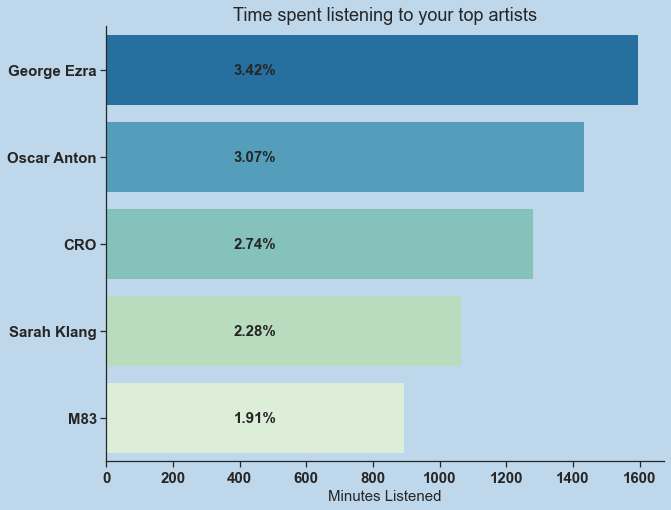

C:\Users\jackl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


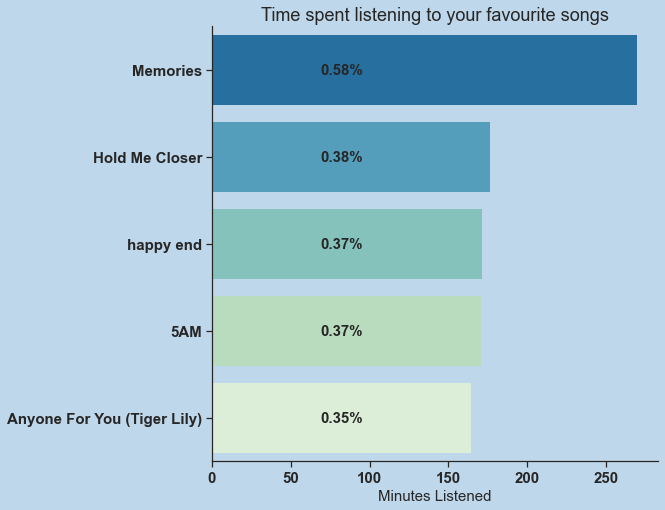

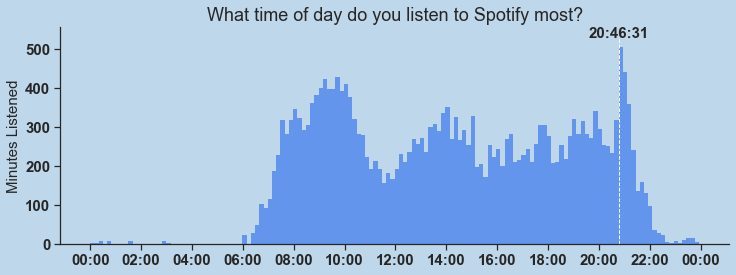

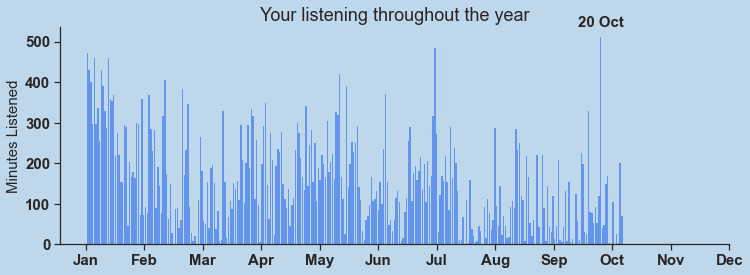

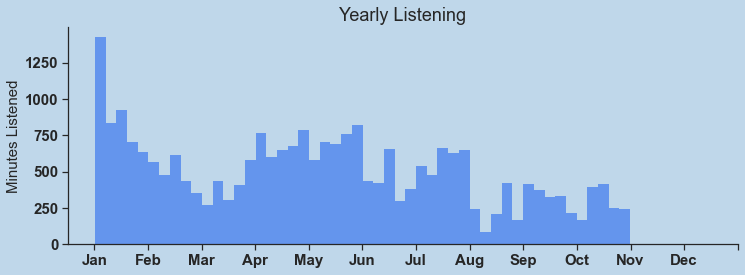

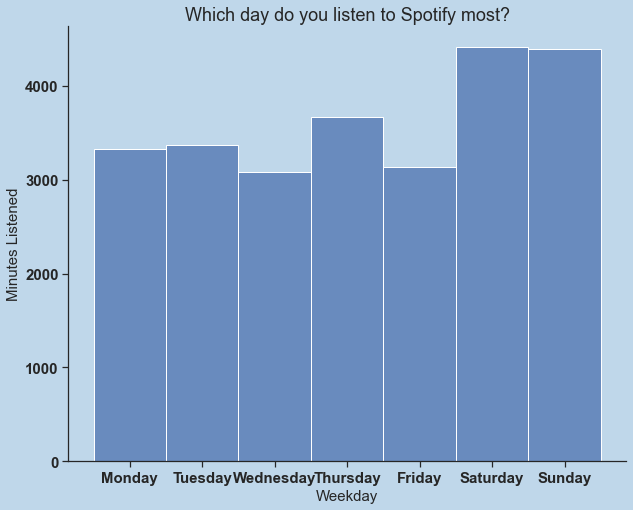

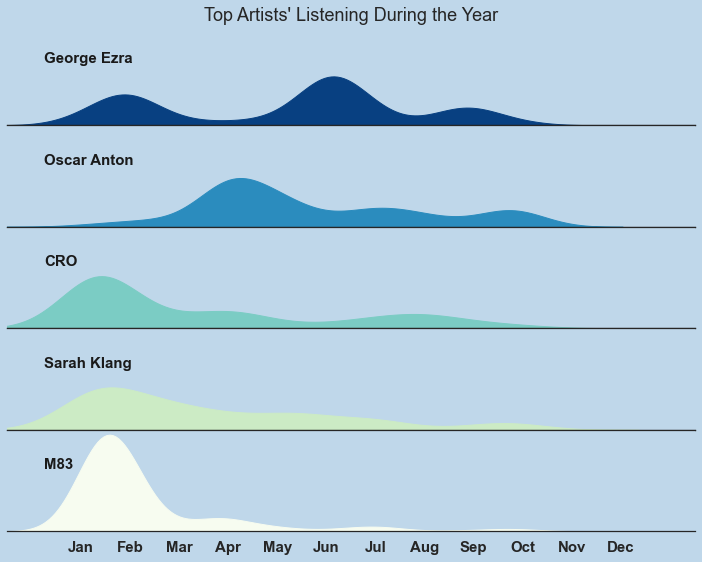

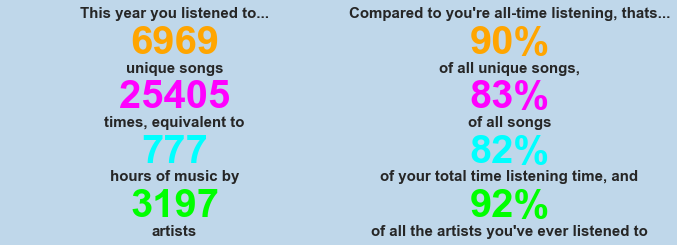

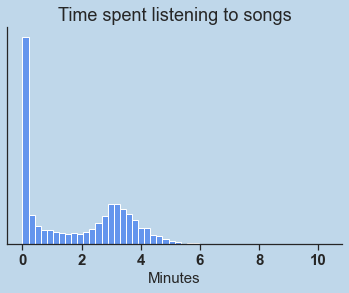

In [11]:
TopArtists(stream_hist)
TopSongs(stream_hist)
TimeOfDay(stream_hist)
TimeOfYear(time_listened_per_day)
TimeOfYearHistogram(stream_hist)
DayOfWeek(stream_hist)
TopArtistsTimeOfYear(stream_hist, artists)
NumberStatistics(stream_hist)
SongListeningTime(stream_hist)

In [12]:
playlists = LoadJSONPlaylists("MyData", "Playlist1")
num_playlists = len(playlists)
playlists['Songs'] = playlists.apply(lambda x: len(x['items']), axis=1)
# print(playlists.columns)
# print(playlists)
# plt.hist(stream_hist['msPlayed']/(1000*60), color='cornflowerblue', bins=50)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.gca().get_yaxis().set_visible(False)
# plt.gca().get_xaxis().tick_bottom()
# plt.xlabel("Minutes")
# plt.ylabel("")
# plt.title("Time spent listening to songs")
# plt.savefig("SongListeningTime.png", dpi=300, format='png', bbox_inches='tight')
# plt.show()
# plt.bar(playlists['name'], playlists['Songs'])
# plt.xticks(rotation = 90)
# plt.show()